In [2]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn
import missingno 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from jupyterthemes import jtplot
# change plotting style to match the theme
jtplot.style()

%matplotlib inline

# Approach

1. I will first want to understand the type of data that is available and identify any interesting correlations or insights.

2. Next, I will build upon the knowledge obtained at step 1 through a visualisation of the entire traffic roadmap. The reason for doing this is to get a high level understanding of accident clusters.

3. For predicting the traffic accident hotspots, I will build a predictive model based on kerned density estimation - inspired from https://link.springer.com/article/10.1007/s40534-015-0068-0. This approach was chosen because it is fairly simple and common in road safety research. Alternatives could have included: K-means, hierarhical nearest neighbours (NNH) or Getis-Ord Gi statistic for hotspot analysis.

4. Finally, I will evaluate the results and highlight some interesting findings.

# Data Analysis

## Accidents Analysis

In [4]:
accidents_data = pd.DataFrame()
casualties_data = pd.DataFrame()
vehicles_data = pd.DataFrame()

# The datasets could have been loaded directly from the website with pandas.read_csv method, I prefered 
# to have a local copy of them as well and have them loaded from the local directory.
# All data is captured from https://data.gov.uk/dataset/road-accidents-safety-data

for cat in ['Accidents', 'Casualties', 'Vehicles']:
    for i in os.listdir(cat):
        if '.csv' in i:
            # Build data for each category.
            path = cat + '/' + i
            if 'Accidents' in i:
                accidents_data = accidents_data.append(pd.read_csv(path, low_memory=False))
            elif 'Casualties' in i:
                casualties_data = casualties_data.append(pd.read_csv(path, low_memory=False))
            elif 'Vehicles' in i:
                vehicles_data = vehicles_data.append(pd.read_csv(path, low_memory=False))

vehicles_data = vehicles_data[vehicles_data['Accident_Index'].isin(accidents_data['Accident_Index'])]

casualties_data = casualties_data[casualties_data['Accident_Index'].isin(accidents_data['Accident_Index'])]

accidents_data['Date'] = pd.to_datetime(accidents_data['Date'])
accidents_data = accidents_data[accidents_data['Date'] > '01/01/2012']

# Remove entries with missing coordinates
accidents_data.dropna(subset = ['Longitude','Latitude'], inplace=True)

/anaconda/envs/tensor/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [5]:
# Most of the data is numerical
accidents_data.dtypes.reset_index()

index               0
0                                Accident_Index          object
1                         Location_Easting_OSGR         float64
2                        Location_Northing_OSGR         float64
3                                     Longitude         float64
4                                      Latitude         float64
5                                  Police_Force           int64
6                             Accident_Severity           int64
7                            Number_of_Vehicles           int64
8                          Number_of_Casualties           int64
9                                          Date  datetime64[ns]
10                                  Day_of_Week           int64
11                                         Time          object
12                   Local_Authority_(District)           int64
13                    Local_Authority_(Highway)          object
14                               1st_Road_Class           int64
15                              1st_Road_Number           int64
16                                    Road_Type           int64
17                                  Speed_limit         float64
18                              Junction_Detail           int64
19                             Junction_Control           int64
20                               2nd_Road_Class           int64
21                              2nd_Road_Number           int64
22            Pedestrian_Crossing-Human_Control           int64
23      Pedestrian_Crossing-Physical_Facilities           int64
24                             Light_Conditions           int64
25                           Weather_Conditions           int64
26                      Road_Surface_Conditions           int64
27                   Special_Conditions_at_Site           int64
28                          Carriageway_Hazards           int64
29                          Urban_or_Rural_Area           int64
30  Did_Police_Officer_Attend_Scene_of_Accident           int64
31                    LSOA_of_Accident_Location          object

In [6]:
print('Number of casualties: %s' % sum(accidents_data['Number_of_Casualties']))
print('Number of accidents: %s' % len(accidents_data))
print('Average victims: %s' % round(sum(accidents_data['Number_of_Casualties']) / len(accidents_data), 2))

Number of casualties: 941026
Number of accidents: 706947
Average victims: 1.33


In [7]:
# Looks like more than 75% of the accidents involved 1 casualty. 
accidents_data['Number_of_Casualties'].describe()

count    706947.000000
mean          1.331113
std           0.810705
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          93.000000
Name: Number_of_Casualties, dtype: float64

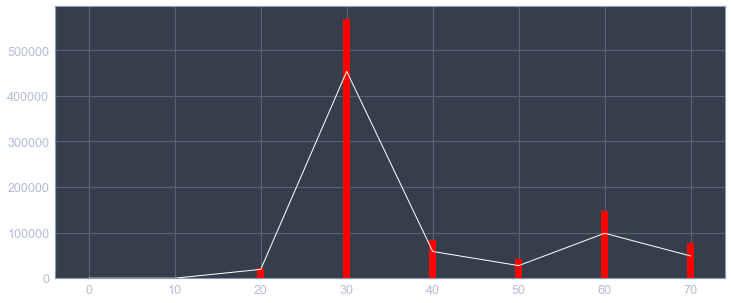

In [8]:
# It seems that areas with a speed limit of 30mph are prone to more accidents. 
# These are probably urban or rural areas. 
accidents_casualties = pd.DataFrame(accidents_data.groupby('Speed_limit').sum()['Number_of_Casualties'])
accidents_casualties['count'] = accidents_data.groupby('Speed_limit').count()['Number_of_Casualties']

fig = plt.figure(figsize=(12, 5))
plt.bar(accidents_casualties.index, accidents_casualties['Number_of_Casualties'], color='red', linewidth=3, zorder=2)
plt.plot(accidents_casualties.index, accidents_casualties['count'], color='white', linewidth=1, zorder=3)

In [9]:
# However, the average number of casualties per accident is higher in 'high speed' areas such as highways
accidents_casualties['Number_of_Casualties'] / accidents_casualties['count']

del accidents_casualties
gc.collect()

7

60

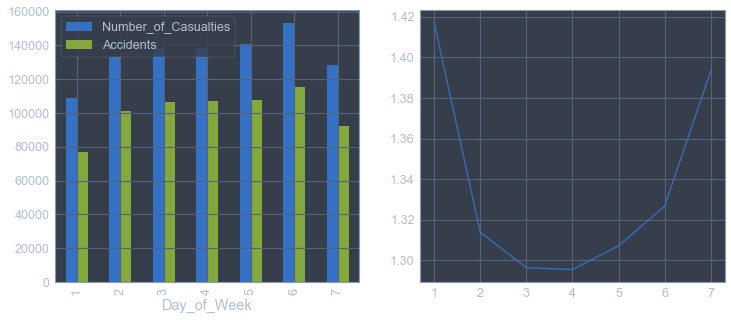

In [10]:
# Casualties and accidents distribution per days of week.
# Weekends (Saturday(7) and Sunday(1)) seem to have less accidents and casualties. But more casualties per accident.
# Fridays on the other hand are more likely to have accidents.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

casualties_day = accidents_data.groupby('Day_of_Week').sum()[['Number_of_Casualties']]
casualties_day['Accidents'] = accidents_data.groupby('Day_of_Week').count()['Accident_Index']

casualties_day.plot(kind='bar', ax=axes[0])
plt.plot(casualties_day['Number_of_Casualties'] / casualties_day['Accidents'])

del casualties_day
gc.collect()

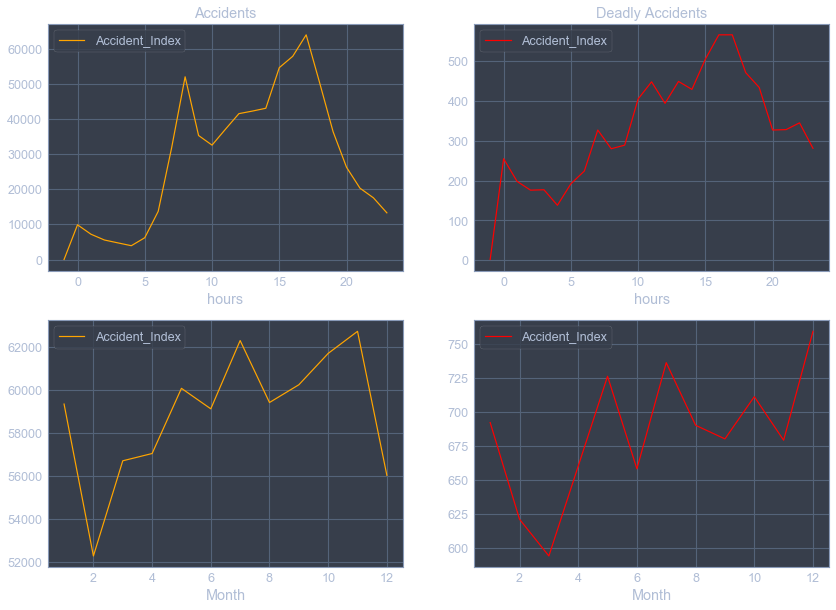

In [11]:
# We can explore temporal trends of the occurred accidents across the road network. 
# The dataset provides us with the hour and minute of an accident. The plots below
# show 5 years worth of accidents and their distribution across the day. We can notice
# that accidents are more prevalent during peak hours - 7AM to 9AM and 4PM to 6PM.
# Lethal accidents (right chart) seem to follow a similar pattern, with more lethal
# accidents taking place late in the evening and early in the morning.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
accidents_data['hours'] = accidents_data['Time'].apply(lambda x: int(str(x)[:2]) if pd.notnull(x) else -1)
accidents_data.groupby('hours').count()[['Accident_Index']].plot(color='orange', ax=axes[0,0], title='Accidents')
accidents_data[accidents_data['Accident_Severity'] == 1].groupby('hours').count()[['Accident_Index']].plot(color='red', ax=axes[0,1], title='Deadly Accidents')

# It is interesting to notice that in december, although the total number of accidents have decreased,
# the proportion of lethal accidents has increased. This might be caused by an overall tendency of 
# the drivers to drive more carefully while those who don't face worse repercussions.
accidents_data['Month'] = accidents_data['Date'].apply(lambda x: x.month)
accidents_data.groupby('Month').count()[['Accident_Index']].plot(color='orange', ax=axes[1,0])
accidents_data[accidents_data['Accident_Severity'] == 1].groupby('Month').count()[['Accident_Index']].plot(color='red', ax=axes[1,1])


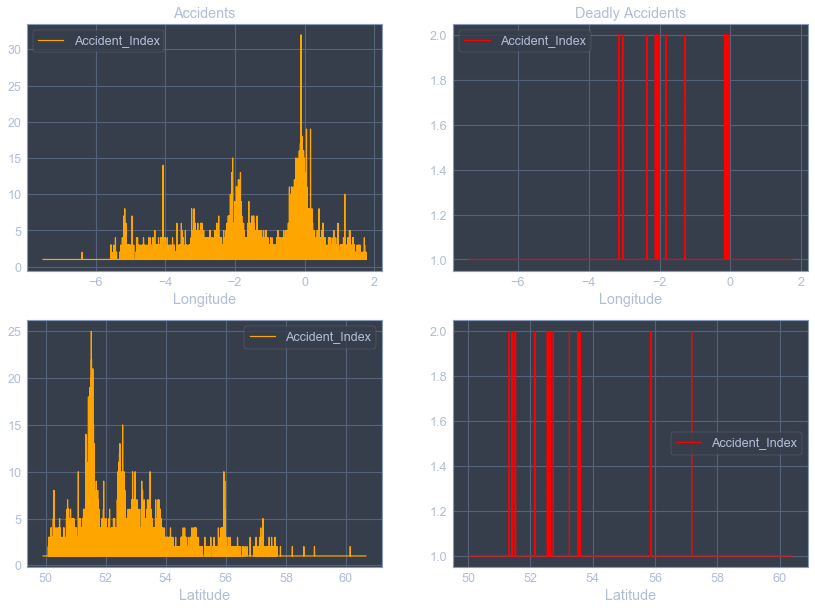

In [12]:
# Distribution of the 706981 accidents across latitude and longitude.
# It seems that most of the accidents occurred between lat 50 and 54 and lon -2 and 2
# Most deadly accidents seem to group up around several coordinates, however, there are only 8206 fatal accidents.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
accidents_data.groupby('Longitude').count()[['Accident_Index']].plot(color='orange', ax=axes[0,0], title='Accidents')
accidents_data.groupby('Latitude').count()[['Accident_Index']].plot(color='orange', ax=axes[1,0])

accidents_data[accidents_data['Accident_Severity'] == 1].groupby('Longitude').count()[['Accident_Index']].plot(color='red', ax=axes[0,1], title='Deadly Accidents')
accidents_data[accidents_data['Accident_Severity'] == 1].groupby('Latitude').count()[['Accident_Index']].plot(color='red', ax=axes[1,1])


In [13]:
# The mean daily number of casualties across the UK appears to be about 2190, with a std. of 7801.
# It looks like we have some extreme values in the dataset, which are in the region of 43 sigma. 
accidents_data.groupby('Date').sum()['Number_of_Casualties'].describe()

count    1826.000000
mean      515.348302
std        87.700644
min       197.000000
25%       460.250000
50%       519.000000
75%       573.000000
max       845.000000
Name: Number_of_Casualties, dtype: float64

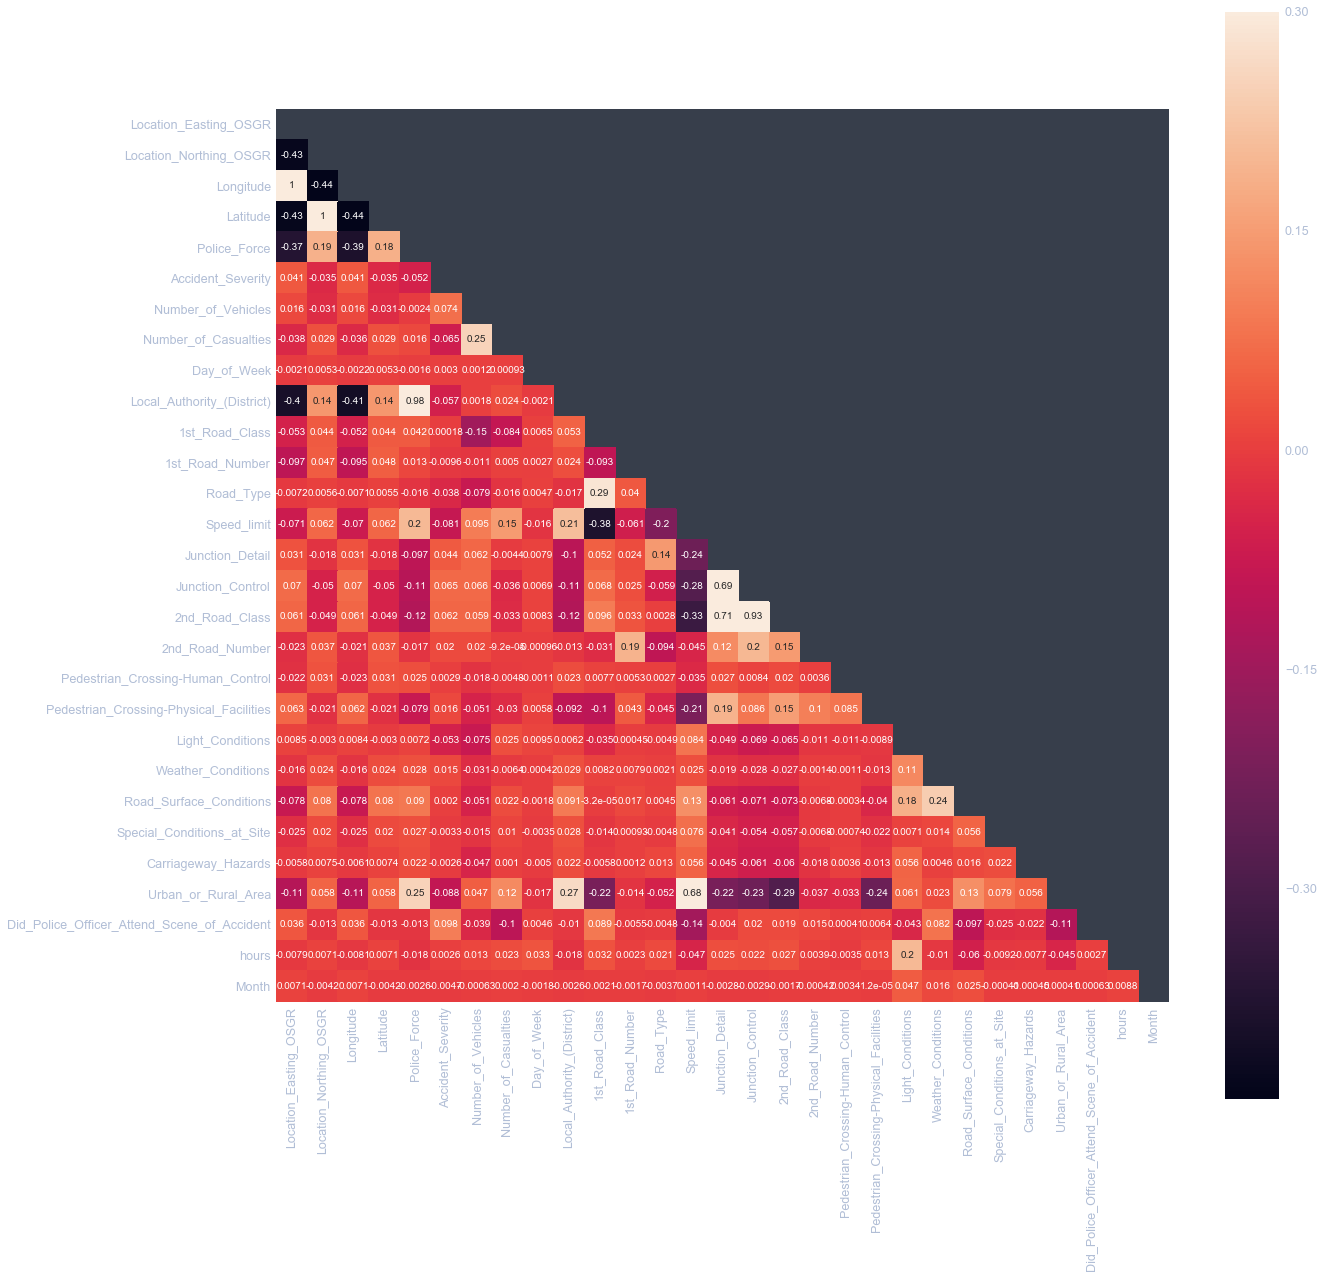

In [14]:
# 'Label' = 'Number of casualties'
# The number of vehicles involved in the accident is, as expected, highly correlated with the label
# Casualty and vehicle reference seem to capture some of the variance in the label.
# As expected, speed limit is positively correlated with the severity of the label. 
# Accidents involving rural areas, bad weather and buses seem to be linked with a higher number of casualties
# Accidents with a higher severity seem to have less casualties. The availability of a police officer at
# the scene of the accident seems to lower the number of casualties -> less remote area?
fig, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(accidents_data.corr())
mask[np.triu_indices_from(mask)] = True
ax = seaborn.heatmap(accidents_data.corr(), ax=ax, mask=mask, vmax=.3, square=True, annot=True)

## Vehicle Analysis

In [15]:
# We can look at both multiple accidents - involving multiple casualties and sole ones.
all_vehicles = vehicles_data.groupby('Accident_Index').count()['Age_Band_of_Driver']

Multi-casualty accidents:  1917274


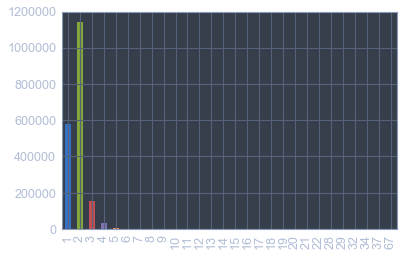

In [16]:
# Most accidents involved 2 casualties. We can extend the analysis at a lower casualty segmentation
# However, for this exercise we will examine the distribution of accident types and continue with 
# some high level conclusions.
# The data seems to follow a distribution highly skewed to the right. 
print('Multi-casualty accidents: ', len(all_vehicles))
all_vehicles.value_counts().sort_index().plot(kind='bar')

309

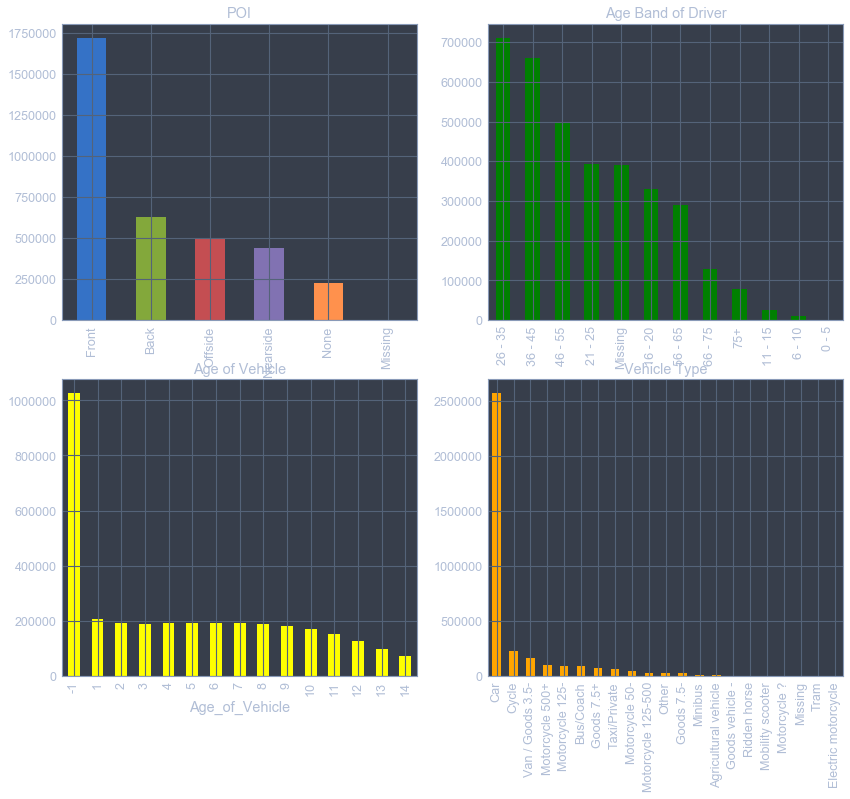

In [17]:
# Some of the interesting things to look at: 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))

# Most frequently, the collision is frontal, as expected.
# 1st_Point_of_Impact
poi = vehicles_data.groupby('1st_Point_of_Impact').count()['Accident_Index']
poi.index = ['Missing','None','Front','Back','Offside','Nearside']
poi.sort_values(ascending=False).plot(kind='bar', title='POI', ax=axes[0,0])

# Looks like most frequent accidents ariginate from drivers aged between 26 and 35 years old
# Age band of driver
age_band = vehicles_data.groupby('Age_Band_of_Driver').count()['Accident_Index'].sort_index()
age_band.index = ['Missing','0 - 5','6 - 10','11 - 15','16 - 20','21 - 25','26 - 35','36 - 45','46 - 55','56 - 65','66 - 75','75+']
age_band.sort_values(ascending=False).plot(kind='bar', title='Age Band of Driver', ax=axes[0,1], color='green')

# Newer vehicles seem to be responsible for more accidents.
# Age of vehicle
age_car = vehicles_data.groupby('Age_of_Vehicle').count()['Accident_Index'].head(15)
age_car.plot(kind='bar', title='Age of Vehicle', ax=axes[1,0], color='yellow')

# Cars are the main driver of accidents, followed by cycles.
# Vehicle_Type
veh_type = vehicles_data.groupby('Vehicle_Type').count()['Accident_Index'].sort_index()
veh_type.index = ['Missing','Cycle','Motorcycle 50-','Motorcycle 125-','Motorcycle 125-500','Motorcycle 500+','Taxi/Private','Car','Minibus','Bus/Coach','Ridden horse','Agricultural vehicle','Tram','Van / Goods 3.5-','Goods 7.5-','Goods 7.5+','Mobility scooter','Electric motorcycle','Other','Motorcycle ?','Goods vehicle -']
veh_type.sort_values(ascending=False).plot(kind='bar', title='Vehicle Type', ax=axes[1,1], color='orange')

del poi, age_band, age_car, veh_type
gc.collect()

In [18]:
# Most known drivers live in an urban area
driver_home = vehicles_data['Driver_Home_Area_Type'].value_counts()
driver_home.index = ['Urban','Unknown','Rural','Town']
print(driver_home)

del driver_home
gc.collect()

Urban      2221219
Unknown     683130
Rural       346571
Town        263850
Name: Driver_Home_Area_Type, dtype: int64


5

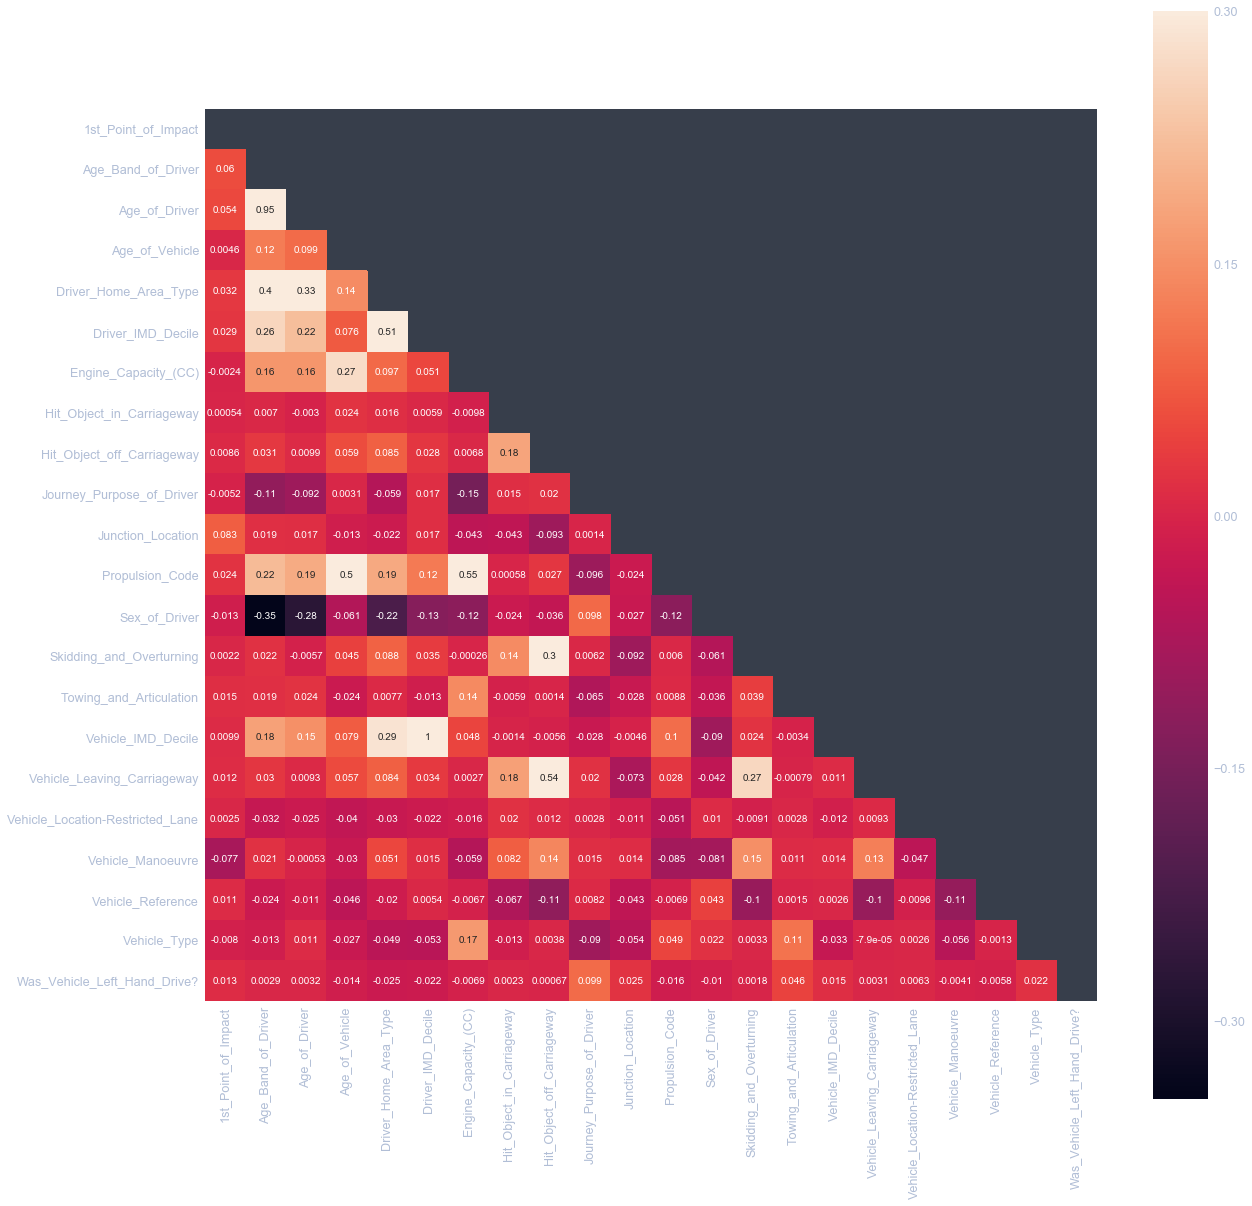

In [19]:
# We can notice some interesting correlations between the driver's age and its home area. Elder drivers
# tend to come from rural areas. 
# Also, accidents casused at the point of a vehicle leaving the carriageway, seem to correlate with an object
# that is being hit and with a vehicle that is overturning and skidding. Not surprising.

fig, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(vehicles_data.corr())
mask[np.triu_indices_from(mask)] = True
ax = seaborn.heatmap(vehicles_data.corr(), ax=ax, mask=mask, vmax=.3, square=True, annot=True)

## Casualties Analysis

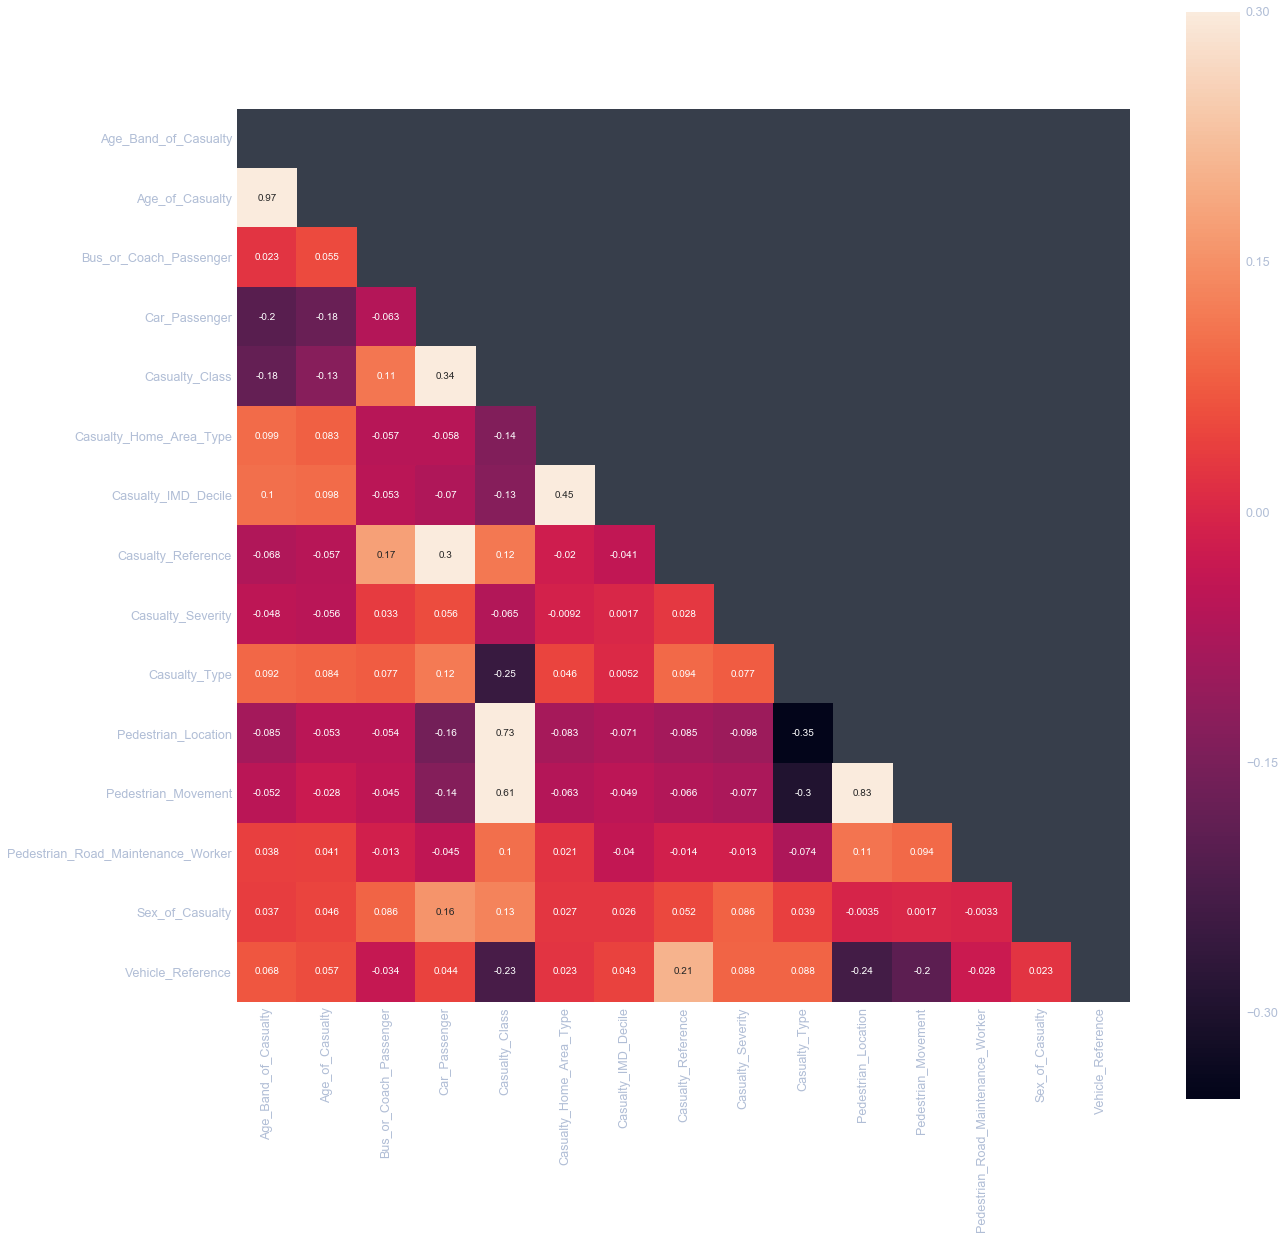

In [20]:
# Brief look at the casualty data. 
# Casualty class seems to be related to pedestrian location and movement. This is simply due to
# the category selection. Class 3 is represented by Pedestrian casualties. Same in the case of negative
# correlations and the location of the casualty and its movement type.
fig, ax = plt.subplots(figsize=(20,20))
mask = np.zeros_like(casualties_data.corr())
mask[np.triu_indices_from(mask)] = True
ax = seaborn.heatmap(casualties_data.corr(), ax=ax, mask=mask, vmax=.3, square=True, annot=True)

In [21]:
del fig, ax, mask, axes
gc.collect()

54074

## Further Analysis

# Visualisation

In [22]:
def map_accidents(data, dotsize=2, colors=['red', 'yellow', 'blue'], _kds=None):
    """
    Maps accidents based on coordinates.
    
    Args:
        data (DataFrame) : Contains Latitude, Longitude and an indicator of 'Accident_Severity'.
        dotsize    (int) : Size of the markers.
        colors    (list) : Colors to use on the map for unique accident severities.
        
    """
    min_lat = data['Latitude'].min()
    max_lat = data['Latitude'].max()
    min_lon = data['Longitude'].min()
    max_lon = data['Longitude'].max()

    area = 0.1
    fig = plt.figure(figsize=(40,40))
    map = Basemap(projection='merc', lat_0 = np.mean([min_lat, max_lat]), lon_0 = np.mean([min_lon, max_lon]),
        resolution = 'h', area_thresh = 0.1,
        llcrnrlon=min_lon - area, llcrnrlat=min_lat - area,
        urcrnrlon=max_lon + area, urcrnrlat=max_lat + area,
        epsg=5520)

    #map.shadedrelief()
    #map.bluemarble()
    map.arcgisimage(service='World_Street_Map', xpixels = 2000, verbose= True)
    #map.drawcoastlines()
    #map.drawcountries()
    #map.fillcontinents(color = 'coral')
    #map.drawmapboundary()

    for c in data['Accident_Severity'].unique():
        
        lon = data[data['Accident_Severity'] == c]['Longitude'].values
        lat = data[data['Accident_Severity'] == c]['Latitude'].values
        x, y = map(lon, lat)
        map.plot(x, y, 'bo', markersize=dotsize, color=colors[c-1])

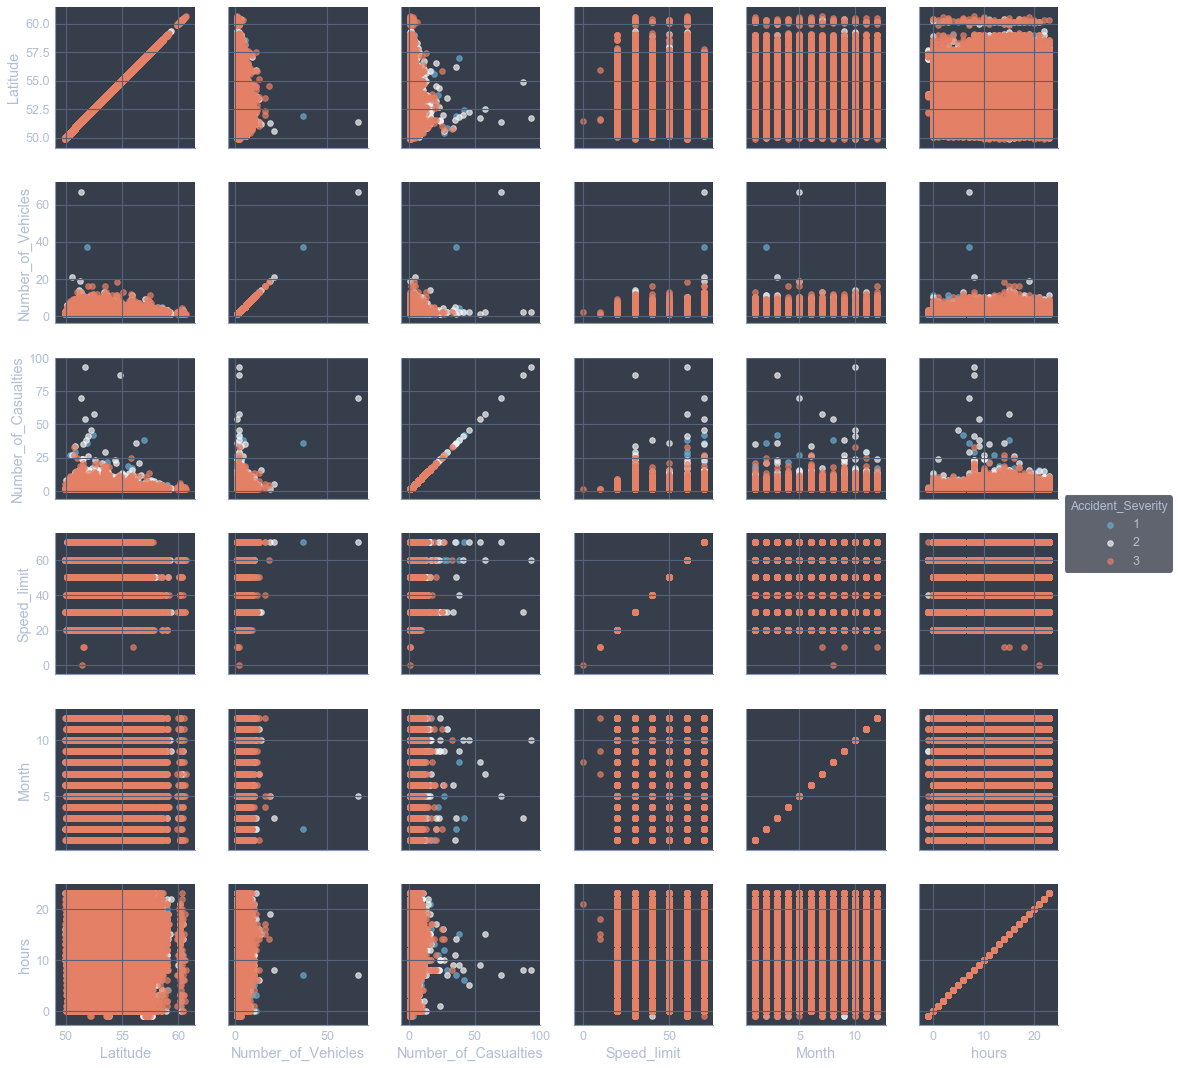

In [23]:
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

coordinates = accidents_data[['Longitude','Latitude']].values
severity = accidents_data['Accident_Severity'].values
#accidents_data.groupby(['Longitude','Latitude']).count()
coordinates *= np.pi / 180.

kde = KernelDensity(bandwidth=0.03, metric='haversine')
kde.fit(np.radians(coordinates[severity == 1]))


g = seaborn.PairGrid(accidents_data, 
                     vars=['Latitude','Number_of_Vehicles','Number_of_Casualties','Speed_limit','Month','hours'],
                 hue='Accident_Severity', palette='RdBu_r')
g.map(plt.scatter, linewidth=1, alpha=0.7)
g.add_legend();

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=737262.4910088866,5573707.553433198,1437830.946727713,6738708.742230334&bboxSR=5520&imageSR=5520&size=2000,3325&dpi=96&format=png32&f=image


/anaconda/envs/tensor/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/envs/tensor/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/envs/tensor/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/envs/tensor/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/anaconda/envs/tensor/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecation

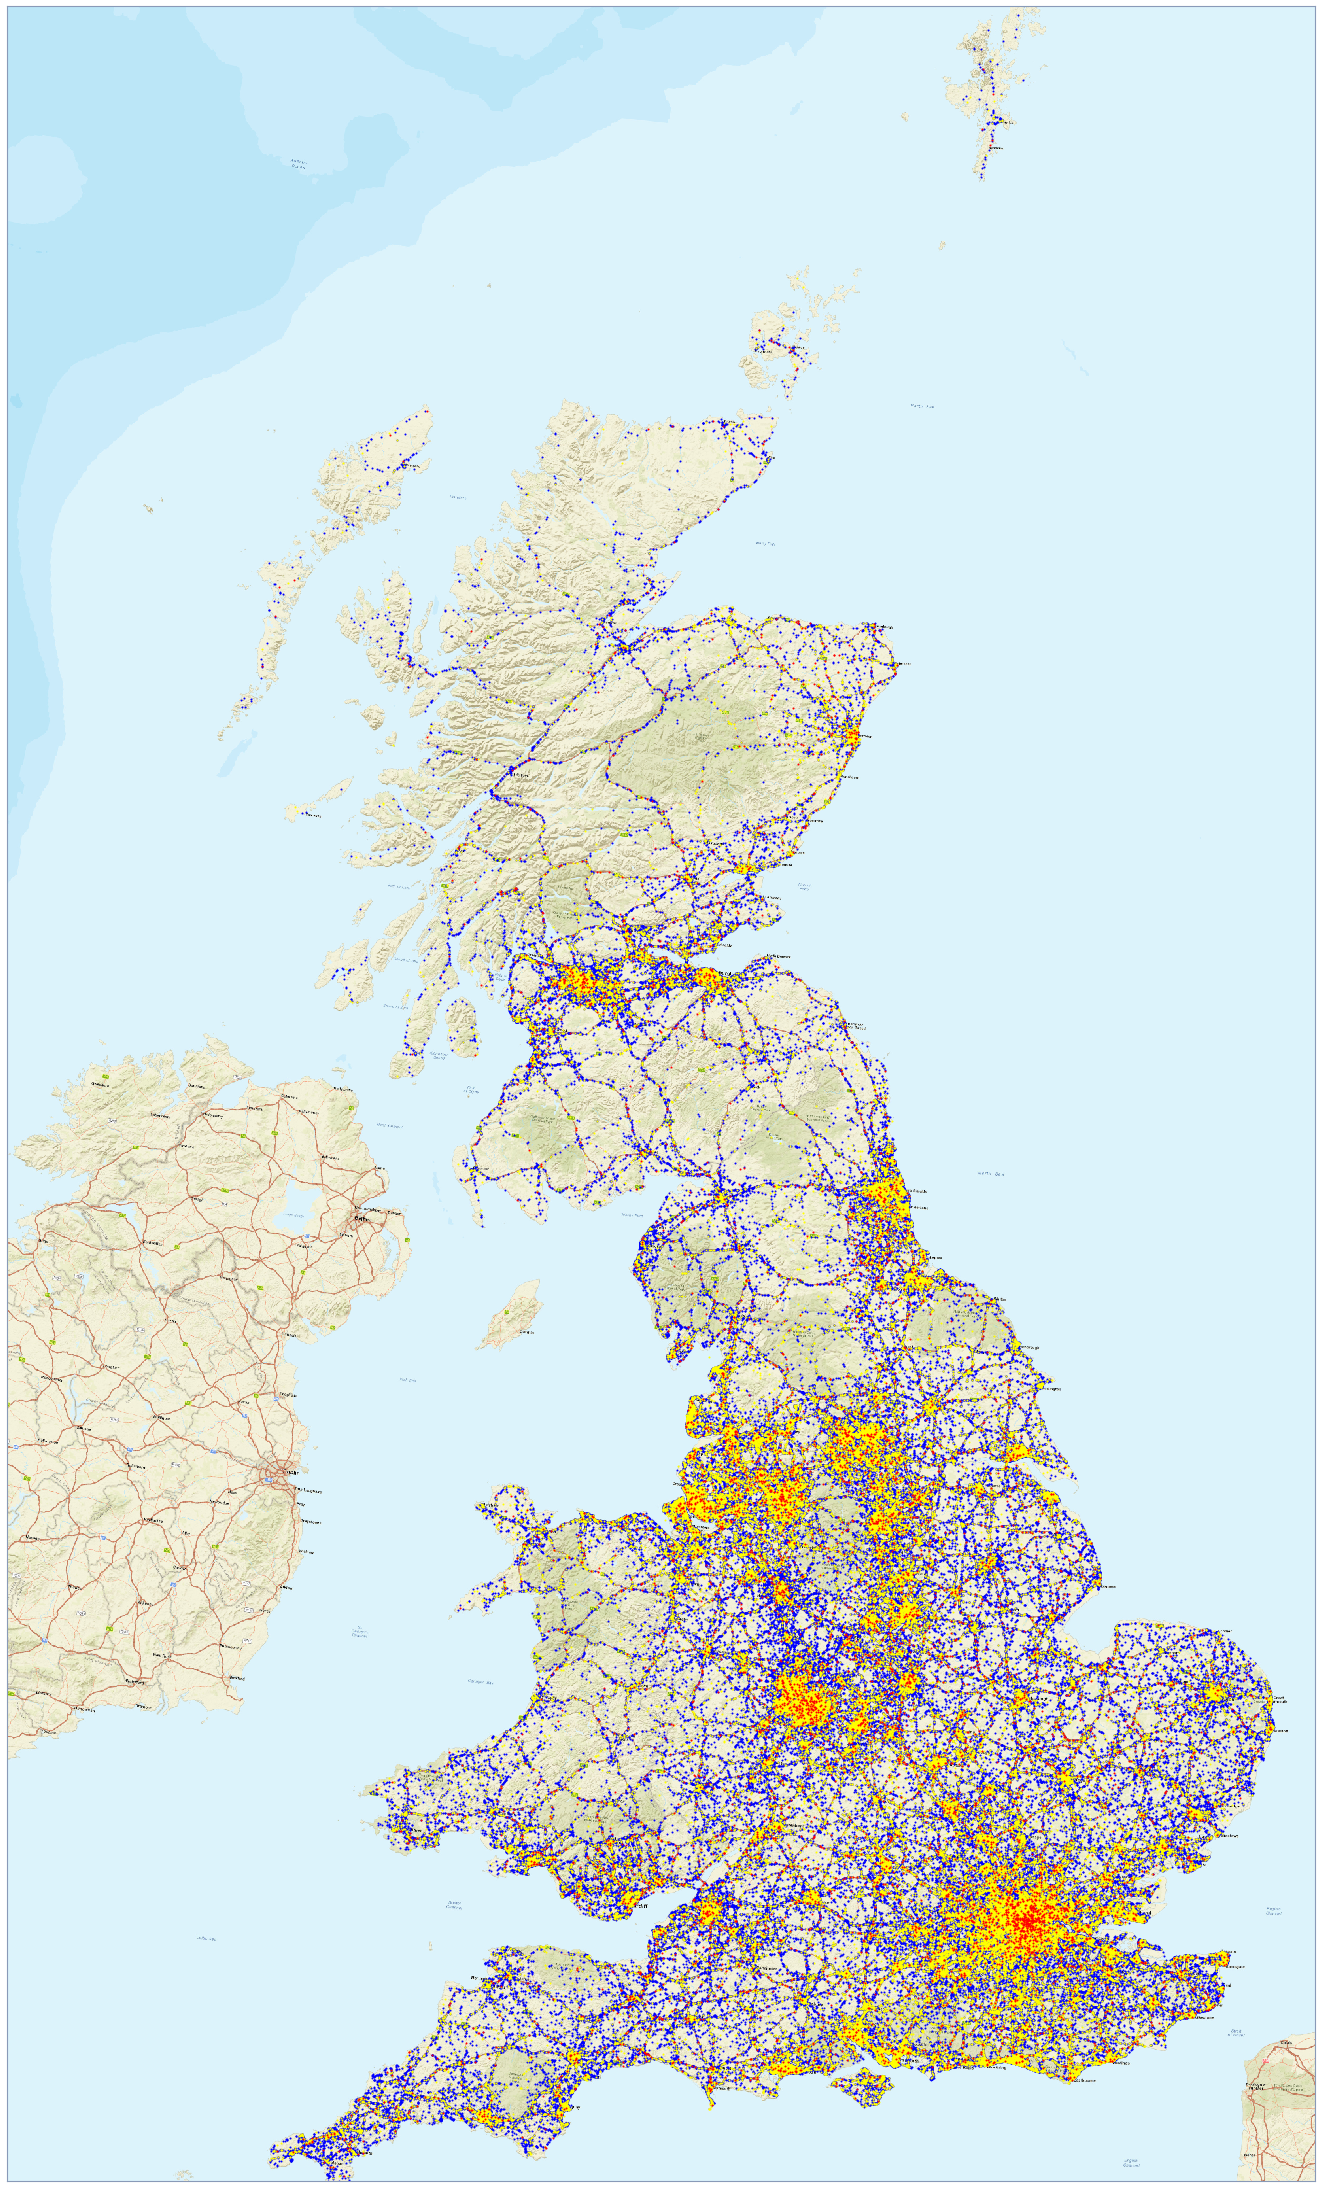

In [25]:
map_accidents(accidents_data)

# Some of the identified hotspots seem to be London, Birmingham, Manchester, Leeds, Portsmouth, 
# Newcastle, Bristol, Nottingham, Glasgow and Edinburgh.

# Also, the highest density of traffic accidents seems to be recorded in the Southern half of the UK.

# We will look at the distribution of accidents on latitude and longitude for validating the 
# insight drawn from the map. 

#accidents_data.groupby('Longitude').count()['Accident_Index']
#accidents_data.groupby('Latitude').count()['Accident_Index']

In [26]:
casualties_features = ['Age_Band_of_Casualty', 'Bus_or_Coach_Passenger', 'Car_Passenger', 
    'Casualty_Class', 'Casualty_Home_Area_Type', 'Casualty_Reference', 'Casualty_Severity', 
    'Casualty_Type', 'Pedestrian_Location', 'Pedestrian_Movement', 
    'Pedestrian_Road_Maintenance_Worker', 'Sex_of_Casualty']
final_casualties_features = casualties_features + ['Accident_Index']

casualties_data = pd.get_dummies(casualties_data[final_casualties_features], columns=casualties_features).groupby('Accident_Index').sum().reset_index()
casualties_data = casualties_data[[c for c in casualties_data.columns if '-1' not in c]]

#############################################################################################

vehicle_features = ['1st_Point_of_Impact', 'Age_Band_of_Driver', 'Driver_Home_Area_Type',
       'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
       'Journey_Purpose_of_Driver', 'Junction_Location', 'Propulsion_Code', 'Sex_of_Driver', 
       'Skidding_and_Overturning', 'Towing_and_Articulation', 
       'Vehicle_Leaving_Carriageway', 'Vehicle_Location-Restricted_Lane', 'Vehicle_Manoeuvre', 
       'Vehicle_Type', 'Was_Vehicle_Left_Hand_Drive?']
final_vehicle_cols = vehicle_features + ['Accident_Index']

vehicles_data = pd.get_dummies(vehicles_data[final_vehicle_cols], columns=vehicle_features).groupby('Accident_Index').sum().reset_index()
vehicles_data = vehicles_data[[c for c in vehicles_data.columns if '-1' not in c]]

accidents = pd.merge(pd.merge(left=accidents_data, right=vehicles_data, on='Accident_Index'), casualties_data, on='Accident_Index')
# Add a day related feature and remove the date.
accidents['Day'] = accidents['Date'].apply(lambda x: x.day)
accidents.drop(['Date', 'Time', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], axis=1, inplace=True)

del casualties_data, vehicles_data
gc.collect()

28

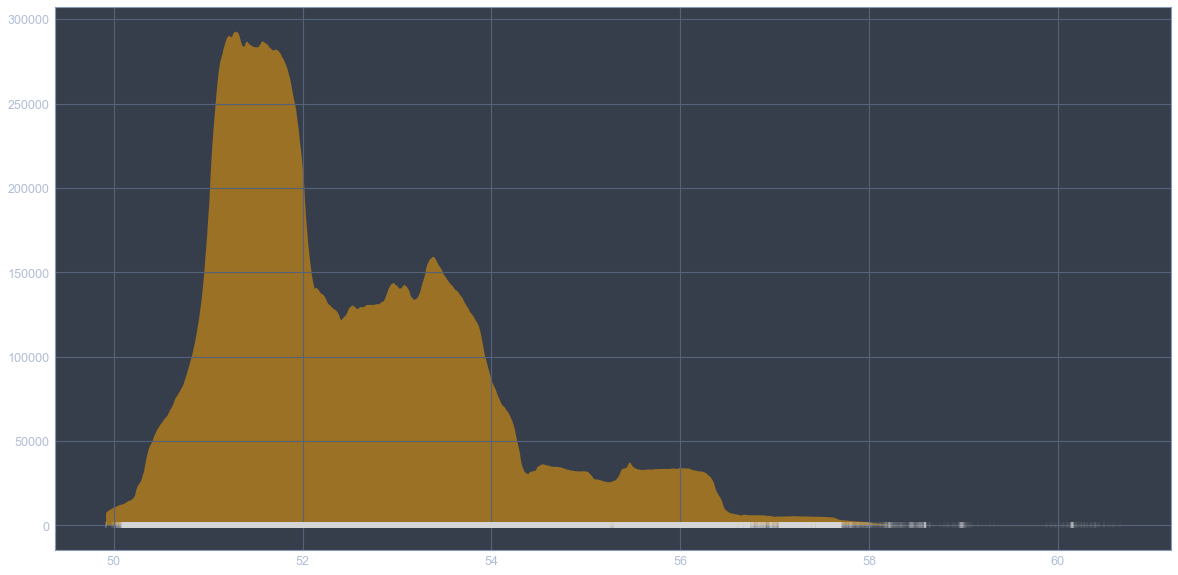

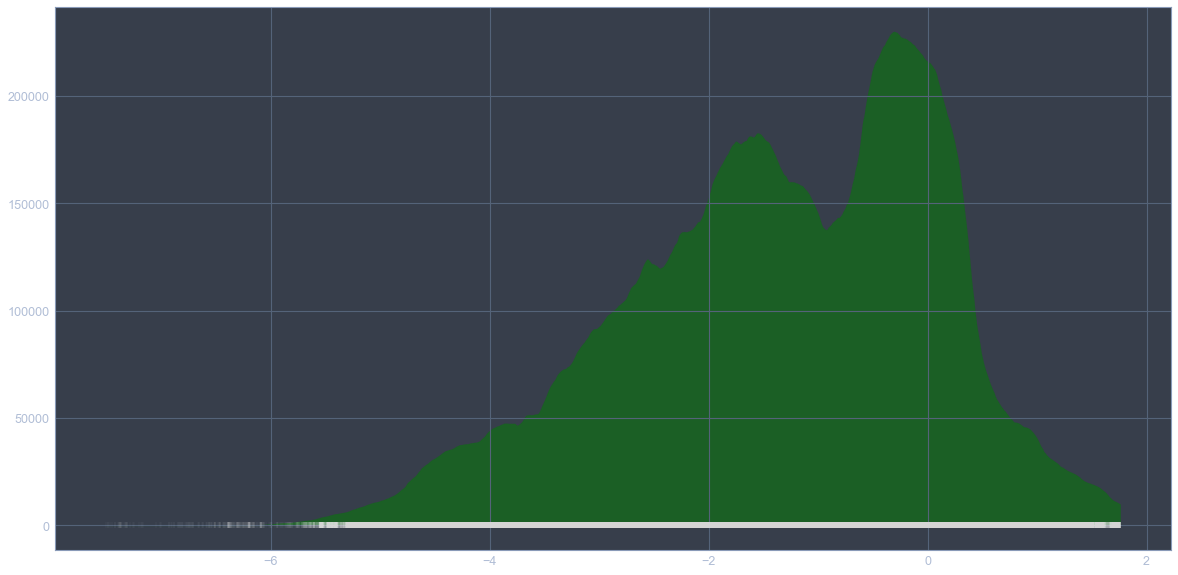

In [27]:
# Distribution of accidents by latitude and longitude using kernel density
planes = ['Latitude','Longitude']
colors = ['orange','green']

for i, plane in enumerate(planes) :
    bins = np.linspace(-5, 10, 10)
    accidents = accidents_data[plane].values
    accidents_d = np.linspace(min(accidents), max(accidents), 2000)

    density = sum((abs(xi - accidents_d) < 0.5) for xi in accidents)
    plt.figure(figsize=(20,10))
    plt.fill_between(accidents_d, density, alpha=0.5, color=colors[i])
    plt.plot(accidents, np.full_like(accidents, -0.1), '|k', markeredgewidth=0.05, color='white')

    #plt.axis([48, 60, -0.2, 8]);